### Initialize Jupyter Notebook and assign GPU

In [288]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load utility functions

In [289]:
from utils import *
from models import *
from dataloader import *
from torch.optim import SGD

In [290]:
import sys
sys.path.insert(1, '/cis/home/adesilva/ashwin/research/ood-tl')

import omegaconf
from imshowtools import imshow
from datahandlers.mnist import RotatedMNISTHandler
from datahandlers.pacs import PACSHandler
from datahandlers.cifar import SplitCIFARHandler, RotatedCIFAR10Handler
from net.wideresnet import WideResNetSingleHeadNet
from PIL import Image

### Set Experiment Configs

In [291]:
#The name of the first and second split datasets. Keep these same
dataset = "split_cifar10"

#Training parameters for first and second split training
weight_decay = 1e-5
peak_lr_pre = 0.1
peak_lr_ft = 0.1
batch_size = 64

#Label Noise Ratio in first and second split
label_noise_ratio_pre = 0.0
label_noise_ratio_ft = 0.0

#Model type and learning schedule
model_type = "resnet9" 
schedule = "cosine" 
seed = 0

#Extra Parameters, not needed
minority_1 = 0
minority_2 = 0

all_args = {"dataset1":None, "dataset2":None, "wd":weight_decay, "lr1":peak_lr_pre, "lr2":peak_lr_ft, 
            "noise_1":label_noise_ratio_pre, "noise_2":label_noise_ratio_ft, "model":model_type, "schedule":schedule,
            "minority_1":minority_1, "minority_2":minority_2, "seed":seed, "batch_size":batch_size, "log_factor":0,"seed_superclass":0}

In [292]:
def set_seed(seed=0):
    """
    Don't set true seed to be nearby values. Doesn't give best randomness
    """
    rng = np.random.default_rng(seed)
    true_seed = int(rng.integers(2**30))

    random.seed(true_seed)
    np.random.seed(true_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(true_seed)
    torch.cuda.manual_seed_all(true_seed)

In [293]:
set_seed(1996)

### Get dataset splits

In [294]:
cfg = omegaconf.OmegaConf.load("/cis/home/adesilva/ashwin/research/ood-tl/config/conf.yaml")

if dataset == 'rotated_mnist':
    # Rotated MNIST
    cfg.task.target_env = 0
    cfg.task.ood_env = 90
    cfg.task.task_map = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
    cfg.hp.bs = batch_size
    n1 = 100
    mn1 = 1
    n2 = 10
    mn2 = 0

if dataset == 'pacs':
    # PACSs
    cfg.task.target_env = 'P'
    cfg.task.ood_env = 'S'
    cfg.task.task_map = [[0,1,4]]
    cfg.hp.bs = batch_size
    n1 = 100
    mn1 = 1
    n2 = 10
    mn2 = 0

if dataset == 'rotated_cifar10':
    # rotated CIFAR10
    cfg.task.target_env = 0
    cfg.task.ood_env = 60
    cfg.task.task_map = [[0,1], [2,3], [4,5], [6,7], [8,9]]
    cfg.task.target = 1
    cfg.task.ood = []
    cfg.hp.bs = batch_size
    n1 = 50
    mn1 = 10
    n2 = 50
    mn2 = 10

if dataset == 'split_cifar10':
    # split CIFAR10
    cfg.task.task_map = [[0,1], [2,3], [4,5], [6,7], [8,9]]
    cfg.task.target = 0
    cfg.task.ood = [3]
    cfg.hp.bs = batch_size
    n1 = 1000
    mn1 = 0.1
    n2 = 50
    mn2 = 0


num_classes = len(cfg.task.task_map[0])

In [295]:
def get_loader(dataset, n, m_n, cfg, seed):
    cfg.task.n = n
    cfg.task.m_n = m_n
    if dataset == 'rotated_mnist':
        dataHandler = RotatedMNISTHandler(cfg)
    if dataset == 'pacs':
        dataHandler =PACSHandler(cfg)
    if dataset == 'rotated_cifar10':
        dataHandler = RotatedCIFAR10Handler(cfg)
    if dataset == 'split_cifar10':
        dataHandler = SplitCIFARHandler(cfg)
    dataHandler.sample_data(seed)
    return dataHandler.get_data_loader(train=True)

In [296]:
seed1 = 1000
seed2 = 3000

preloader = get_loader(dataset, n1, mn1, cfg, seed1)
ftloader = get_loader(dataset, n2, mn2, cfg, seed2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Model Initialization

In [297]:
loss_fn = torch.nn.CrossEntropyLoss()
in_channels = 1 if all_args["dataset1"] == "mnist" else 3
model = get_model(all_args["model"], in_channels=3)

### Model Training

In [298]:
#Stage 1 Training
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler, EPOCHS = get_scheduler_epochs(all_args["schedule"], optimizer, preloader)

ret_pre = train(model, preloader, optimizer, scheduler, loss_fn, EPOCHS = EPOCHS,eval_every = True, eval_loader= preloader)

# torch.save(model.state_dict(), f"models/{all_args['dataset1']}/stage_1.pt")

#Stage 2 Training
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler, EPOCHS = get_scheduler_epochs(all_args["schedule"], optimizer, ftloader)


ret_ft = train(model, ftloader, optimizer, scheduler, loss_fn, EPOCHS = EPOCHS, eval_every = True, eval_loader= preloader)

Epoch: 1 | Eval Loader Accuracy: 84.2273%
Epoch: 2 | Eval Loader Accuracy: 87.9545%
Epoch: 3 | Eval Loader Accuracy: 91.7273%
Epoch: 4 | Eval Loader Accuracy: 93.7273%
Epoch: 5 | Eval Loader Accuracy: 93.0455%
Epoch: 5 | Accuracy: 90.4545% | Loss: 3.51e-03
Epoch: 6 | Eval Loader Accuracy: 95.5455%
Epoch: 7 | Eval Loader Accuracy: 96.9091%
Epoch: 8 | Eval Loader Accuracy: 97.7727%
Epoch: 9 | Eval Loader Accuracy: 99.5455%
Epoch: 10 | Eval Loader Accuracy: 99.4091%
Epoch: 10 | Accuracy: 98.5455% | Loss: 7.05e-04
Epoch: 11 | Eval Loader Accuracy: 99.2273%
Epoch: 12 | Eval Loader Accuracy: 99.8182%
Epoch: 13 | Eval Loader Accuracy: 99.9545%
Epoch: 14 | Eval Loader Accuracy: 100.0000%
Epoch: 15 | Eval Loader Accuracy: 100.0000%
Epoch: 15 | Accuracy: 100.0000% | Loss: 4.23e-05
Epoch: 16 | Eval Loader Accuracy: 100.0000%
Epoch: 17 | Eval Loader Accuracy: 100.0000%
Epoch: 18 | Eval Loader Accuracy: 100.0000%
Epoch: 18 | Accuracy: 100.0000% | Loss: 1.77e-05
Epoch: 1 | Eval Loader Accuracy: 100.

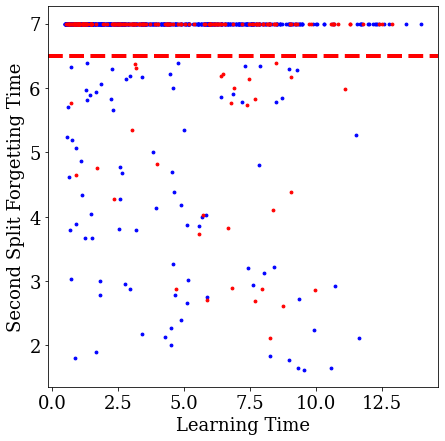

In [299]:
task_ids = np.array(preloader.dataset.targets)[:, 0]

masks_pre = ret_pre["acc_mask"]
masks_ft = ret_ft["acc_mask"]
# noise_mask = pre_dict["noise_mask"]

learn_epochs = get_first_epoch_where_we_learn_forever(masks_pre)
forget_epochs = get_first_epoch_where_we_forget_forever(masks_ft)
learn = learn_epochs + np.random.uniform(-0.5, 0.5, size = learn_epochs.shape)
forget = forget_epochs 
fg = forget_epochs.max()
forget[forget_epochs!=fg] = forget[forget_epochs!=fg] + np.random.uniform(-0.4, 0.4, size = forget_epochs[forget_epochs!=fg].shape)

fig, ax = plt.subplots(figsize=(7, 7))

fontsize = 20
labelsize = 18
lw = 4
markersize = 8

ax.set_xlabel("Learning Time", fontsize=labelsize)
ax.set_ylabel("Second Split Forgetting Time", fontsize=labelsize)

ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)

ax.axhline(y=fg-0.5, color='r', linestyle='--', lw=lw)

ax.scatter(learn[task_ids == 0], forget[task_ids == 0], s= markersize, c = "b")
ax.scatter(learn[task_ids == 1], forget[task_ids == 1], s= markersize, c = "r")

plt.show()

In [300]:
import matplotlib
import numpy as np

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.use('svg')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"

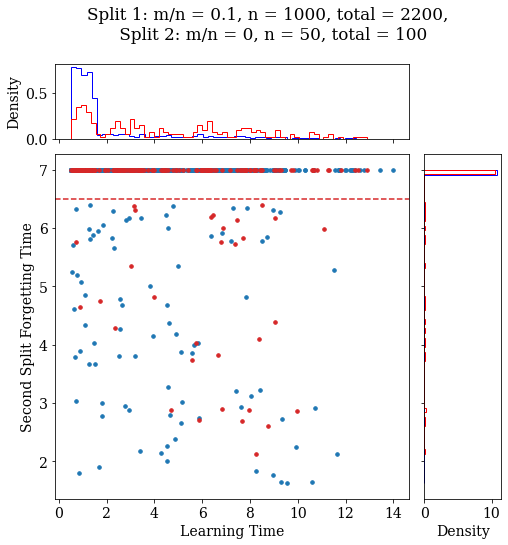

In [301]:
import matplotlib.gridspec as gridspec

x, y  = learn, forget
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(5, 5)
ax_main = plt.subplot(gs[1:, :4])
ax_xDist = plt.subplot(gs[0, :4])#,sharex=ax_main)
ax_yDist = plt.subplot(gs[1:, 4])#,sharey=ax_main)

ax_main.scatter(x[task_ids==0], y[task_ids==0], marker='.',c='tab:blue', s=50)
ax_main.scatter(x[task_ids==1], y[task_ids==1], marker='.',c='tab:red', s=50)
ax_main.set(xlabel="Learning Time", ylabel="Second Split Forgetting Time")
ax_main.axhline(y=fg-0.5, color='tab:red', linestyle='--', c = 'tab:red')

ax_xDist.hist(x[task_ids==0],bins=61,align='mid', fill=False, ec="b", histtype='step', density=True)
ax_xDist.hist(x[task_ids==1],bins=61,align='mid', fill=False, ec="r", histtype='step', density=True)
ax_xDist.set(ylabel='Density')

ax_yDist.hist(y[task_ids==0], bins=61, orientation='horizontal',align='mid', fill=False, ec="b", histtype='step', density=True)
ax_yDist.hist(y[task_ids==1], bins=61, orientation='horizontal',align='mid', fill=False, ec="r", histtype='step', density=True)
ax_yDist.set(xlabel='Density')

ax_yDist.set_yticklabels([])
ax_xDist.set_xticklabels([])

fig.suptitle("Split 1: m/n = {}, n = {}, total = {}, \n Split 2: m/n = {}, n = {}, total = {}".format(mn1, n1, len(preloader.dataset.data), mn2, n2, len(ftloader.dataset.data)))

plt.show()

### Visualize

In [302]:
# # PACS
# idx = (learn_epochs > 12)
# im_array = []
# path_list = preloader.dataset.data[idx][:500]
# for path in path_list:
#     im = np.asarray(Image.open(path[0]))
#     im_array.append(im)
# im_array = np.array(im_array)

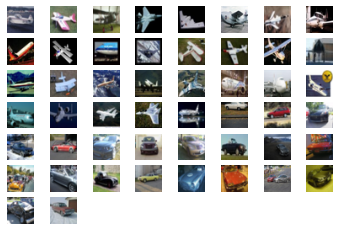

In [303]:
# rotated MNIST / rotated CIFAR-10
idx = (forget_epochs < 5)
imshow(*preloader.dataset.data[idx][:50])